In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')
import os

# Download dataset

In [202]:
import kagglehub

path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/smart-meters-in-london


# Read Datasets

## Read hh_block_0

In [203]:
hh_block_0 = pd.read_csv('/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_0.csv', parse_dates=['day'])

## Read hourly weather dataset

In [204]:
weather = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=['time'], index_col='time')

## block_0 head

In [205]:
hh_block_0.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## weather dataset head

In [206]:
weather.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


# Data Preprocessing

## Filter rows for a specific ID

In [207]:
hh_block_0_filtered = hh_block_0[hh_block_0['LCLid'] == 'MAC000002'].copy()

In [208]:
hh_block_0_filtered.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## Drop the 'LCLid' column

In [209]:
hh_block_0_filtered.drop(columns='LCLid', inplace=True)

In [210]:
hh_block_0_filtered.head()

,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,hh_8,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,0.167,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,0.120,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,0.124,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,0.091,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,0.080,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


##Melt the hh_ columns into one column (long format)

In [211]:
hh_block_0_filtered = hh_block_0_filtered.melt(id_vars=['day'],
                       value_vars=[col for col in hh_block_0_filtered.columns if col.startswith('hh_')],
                       var_name='half_hour',
                       value_name='consumption')

In [212]:
hh_block_0_filtered.head()

,day,half_hour,consumption
0,2012-10-13,hh_0,0.263
1,2012-10-14,hh_0,0.262
2,2012-10-15,hh_0,0.192
3,2012-10-16,hh_0,0.237
4,2012-10-17,hh_0,0.157


## Sort by date and half-hour slot

In [213]:
hh_block_0_filtered['day'] = pd.to_datetime(hh_block_0_filtered['day'])
hh_block_0_filtered = hh_block_0_filtered.sort_values(['day', 'half_hour'])

In [214]:
hh_block_0_filtered.head()

,day,half_hour,consumption
0,2012-10-13,hh_0,0.263
498,2012-10-13,hh_1,0.269
4980,2012-10-13,hh_10,0.168
5478,2012-10-13,hh_11,0.107
5976,2012-10-13,hh_12,0.166


## Extract the half-hour index

In [215]:
hh_block_0_filtered['hh_index'] = hh_block_0_filtered['half_hour'].str.extract('hh_(\d+)').astype(int)

## Create datetime index: date + hh_index * 30 minutes

In [216]:
hh_block_0_filtered['datetime'] = hh_block_0_filtered['day'] + pd.to_timedelta(hh_block_0_filtered['hh_index'] * 30, unit='min')

##Set the datetime index and drop unnecessary columns

In [217]:
hh_block_0_filtered = hh_block_0_filtered.set_index('datetime')[['consumption']]

In [218]:
hh_block_0_filtered.head()

,consumption
datetime,
2012-10-13 00:00:00,0.263
2012-10-13 00:30:00,0.269
2012-10-13 05:00:00,0.168
2012-10-13 05:30:00,0.107
2012-10-13 06:00:00,0.166


In [219]:
hh_block_0_hourly = hh_block_0_filtered.resample("H").mean()

In [220]:
hh_block_0_hourly.head()

,consumption
datetime,
2012-10-13 00:00:00,0.2660
2012-10-13 01:00:00,0.2655
2012-10-13 02:00:00,0.1735
2012-10-13 03:00:00,0.1400
2012-10-13 04:00:00,0.1380


## Join with weather dataset

In [221]:
hh_block_0_hourly_weather = hh_block_0_hourly.join(weather['temperature']).dropna()

In [222]:
hh_block_0_hourly_weather.head()

,consumption,temperature
datetime,,
2012-10-13 00:00:00,0.2660,8.78
2012-10-13 01:00:00,0.2655,8.27
2012-10-13 02:00:00,0.1735,7.87
2012-10-13 03:00:00,0.1400,7.89
2012-10-13 04:00:00,0.1380,7.74


In [223]:
hh_block_0_hourly_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11950 entries, 2012-10-13 00:00:00 to 2014-02-27 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  11950 non-null  float64
 1   temperature  11950 non-null  float64
dtypes: float64(2)
memory usage: 280.1 KB


## Changing Frequencies

In [253]:
hourly_data = hh_block_0_hourly_weather.resample('H').mean()
daily_data = hh_block_0_hourly_weather.resample('D').mean()
weekly_data = hh_block_0_hourly_weather.resample('W').mean()
monthly_data = hh_block_0_hourly_weather.resample('M').mean()
annualy_data = hh_block_0_hourly_weather.resample('A').mean()

# Show some plots

##Original data

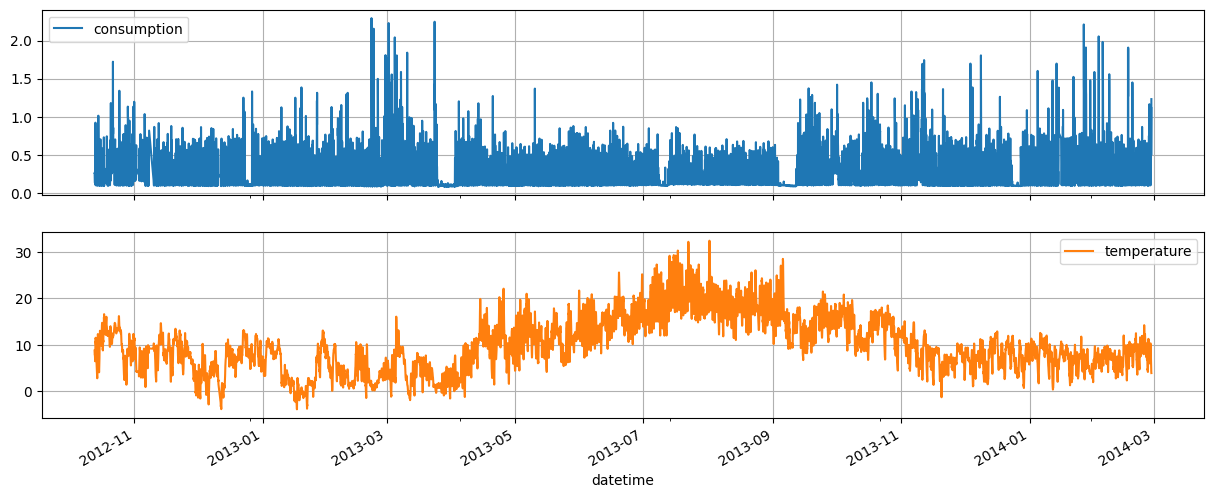

In [254]:
hh_block_0_hourly_weather.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

## Plot differtent Frequencies

- as we can observe the consumption increase when the temprature decreases

### Hourly

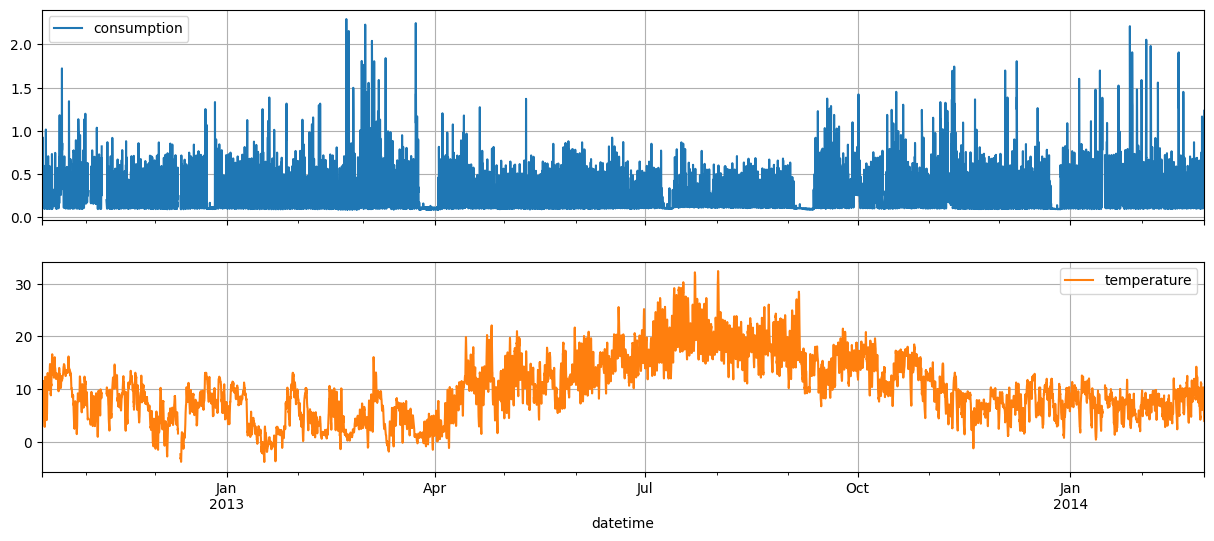

In [255]:
hourly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Daily

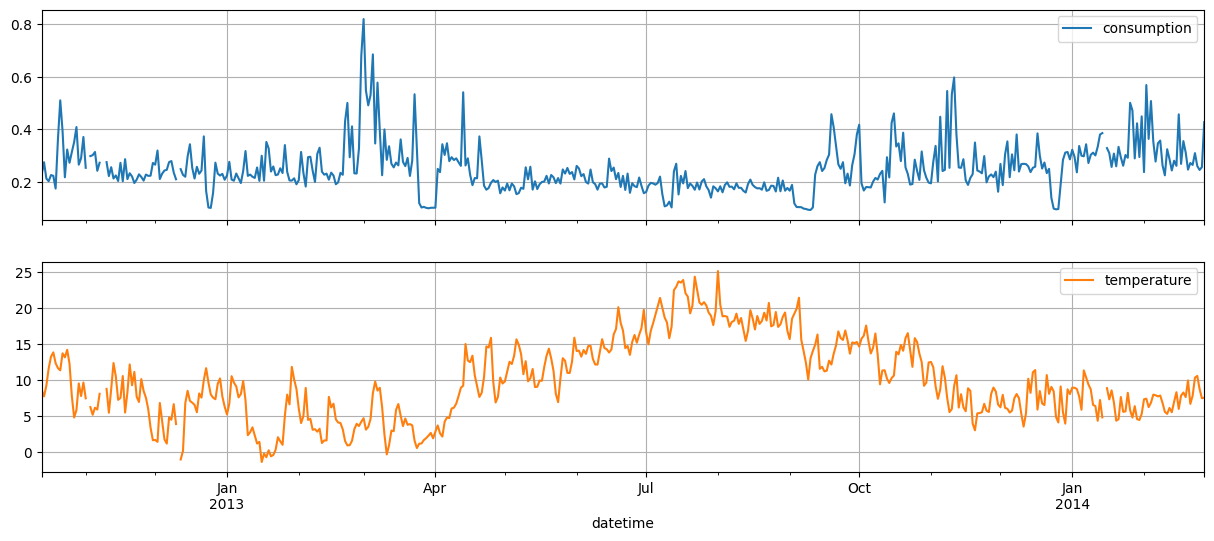

In [227]:
daily_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Weekly

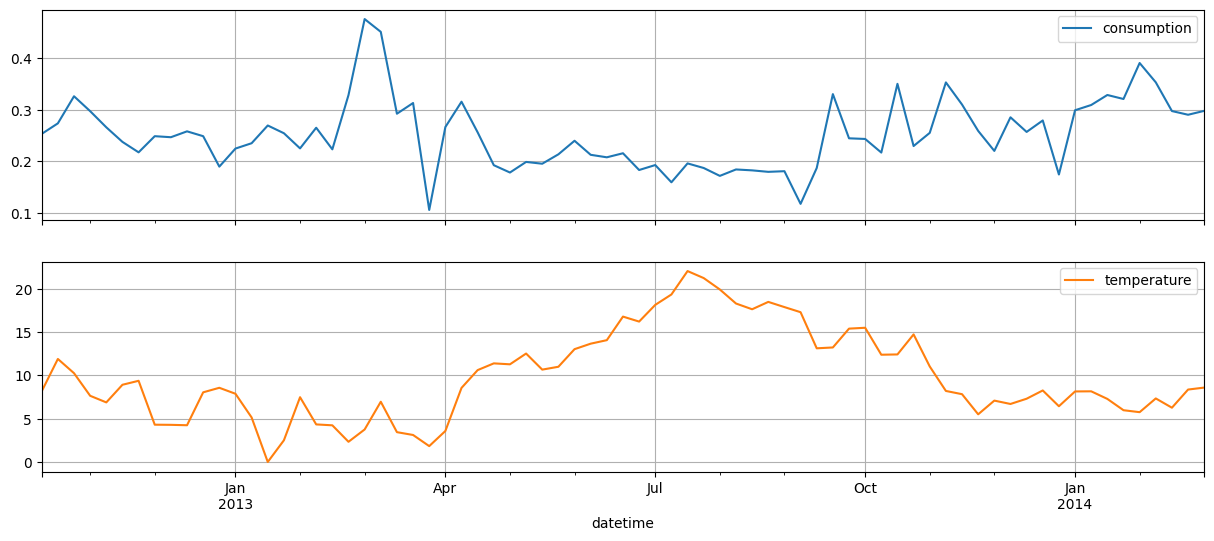

In [228]:
weekly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Monthly

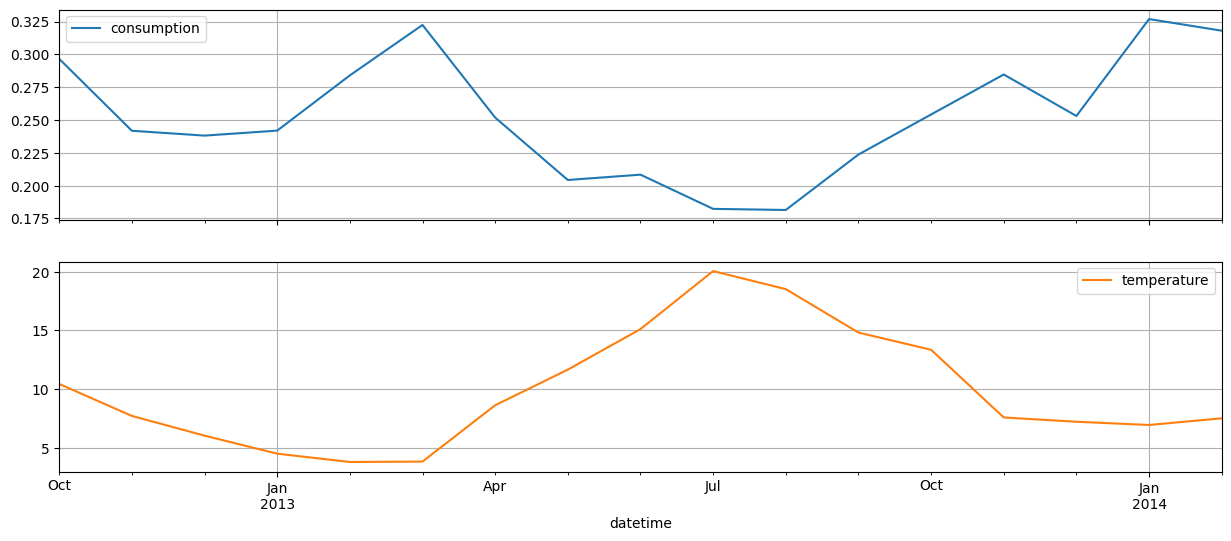

In [229]:
monthly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

## Heatmap to show correlation

- shows a negative correlation

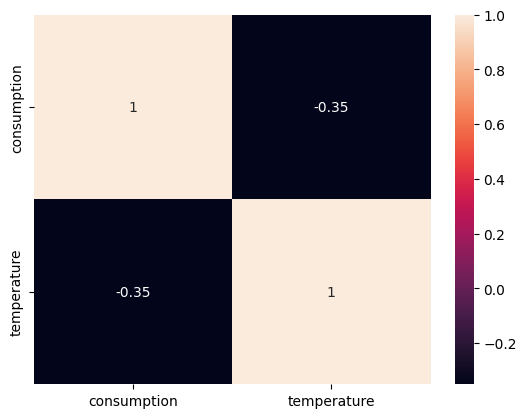

In [230]:
corr = daily_data.corr()
sns.heatmap(correlation, annot=True)
plt.show()

#Decomposition

## Daily Energy Consumption with Moving Average

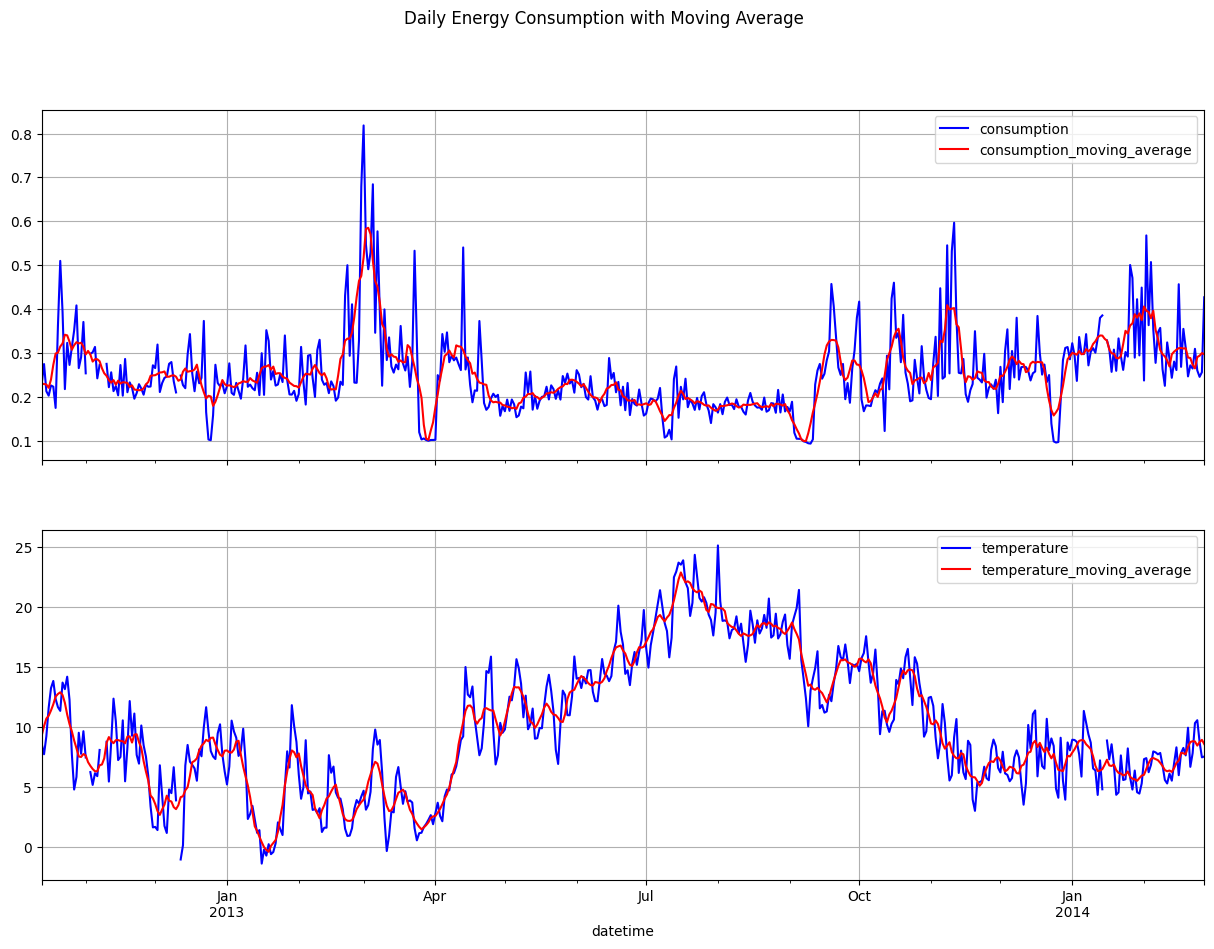

In [231]:
rolling_window = '7D'
trend_ma = daily_data.rolling(window=rolling_window, center=True).mean().add_suffix('_moving_average')
ax = daily_data.plot(subplots=True, title='Daily Energy Consumption with Moving Average', color='blue', figsize=(15, 10), grid=True)
trend_ma.plot(subplots=True, ax=ax, color='red', grid=True)
plt.show()

# Test stationarity for different time aggregations

In [232]:
def test_stationarity(timeseries, title):

    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')

    rolling_mean = timeseries.rolling(window=10).mean()
    rolling_std = timeseries.rolling(window=10).std()

    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')

    plt.title(f'Rolling Statistics for {title} Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    adf_result = adfuller(timeseries.dropna())

    print('ADF Test Results:')
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')

    if adf_result[1] <= 0.05:
        print("Conclusion: Time series is STATIONARY (ADF Test)")
    else:
        print("Conclusion: Time series is NON-STATIONARY (ADF Test)")

    kpss_result = kpss(timeseries.dropna())

    print('\nKPSS Test Results:')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.4f}')

    if kpss_result[1] <= 0.05:
        print("Conclusion: Time series is NON-STATIONARY (KPSS Test)")
    else:
        print("Conclusion: Time series is STATIONARY (KPSS Test)")

    lags = min(40, len(timeseries) // 2 -1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(timeseries.dropna(), ax=axes[0], lags=lags)
    plot_pacf(timeseries.dropna(), ax=axes[1], lags=lags)
    plt.suptitle(f'ACF and PACF for {title} Data')
    plt.tight_layout()
    plt.show()

## For Hourly data

Looking at these charts, I can see this hourly data shows strong patterns. The data clearly has a daily cycle, with peaks appearing every 24 hours on the left chart. The first few hours have the strongest relationship, with each hour heavily influenced by what happened just before it.
The right chart (PACF) confirms this by showing that once you account for the immediate hour-to-hour relationship, most of the apparent patterns disappear, except for the daily cycle that pops up again around the 24-hour mark.
This is typical for hourly measurements where activities follow a daily rhythm

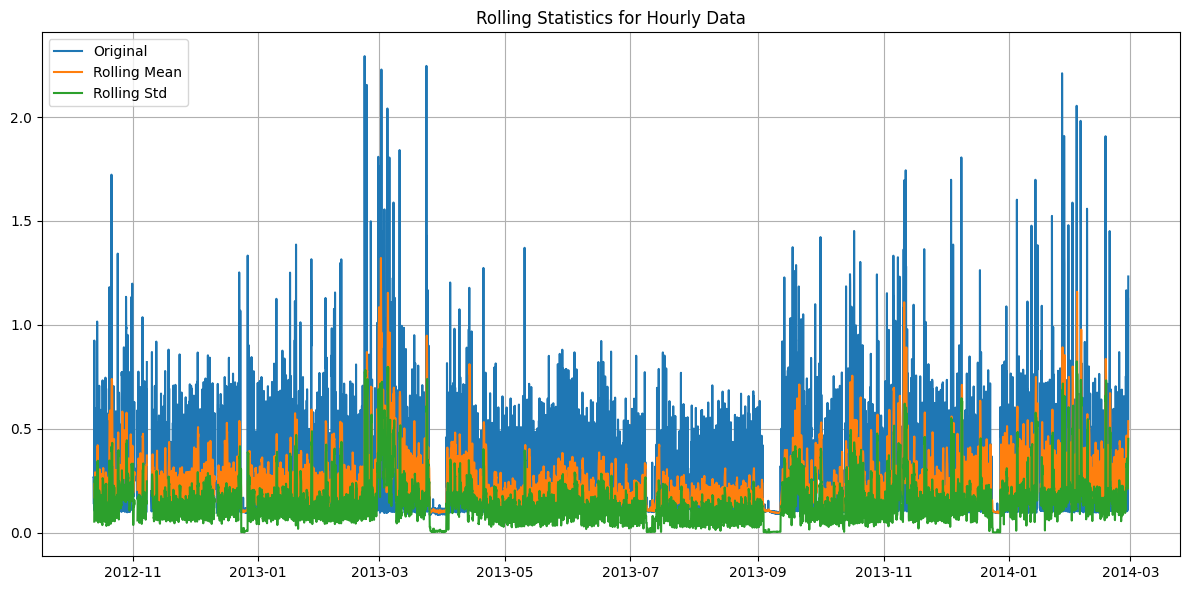

ADF Test Results:
ADF Statistic: -11.2416
p-value: 0.0000
Critical Values:
	1%: -3.4309
	5%: -2.8618
	10%: -2.5669
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 1.4260
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is NON-STATIONARY (KPSS Test)


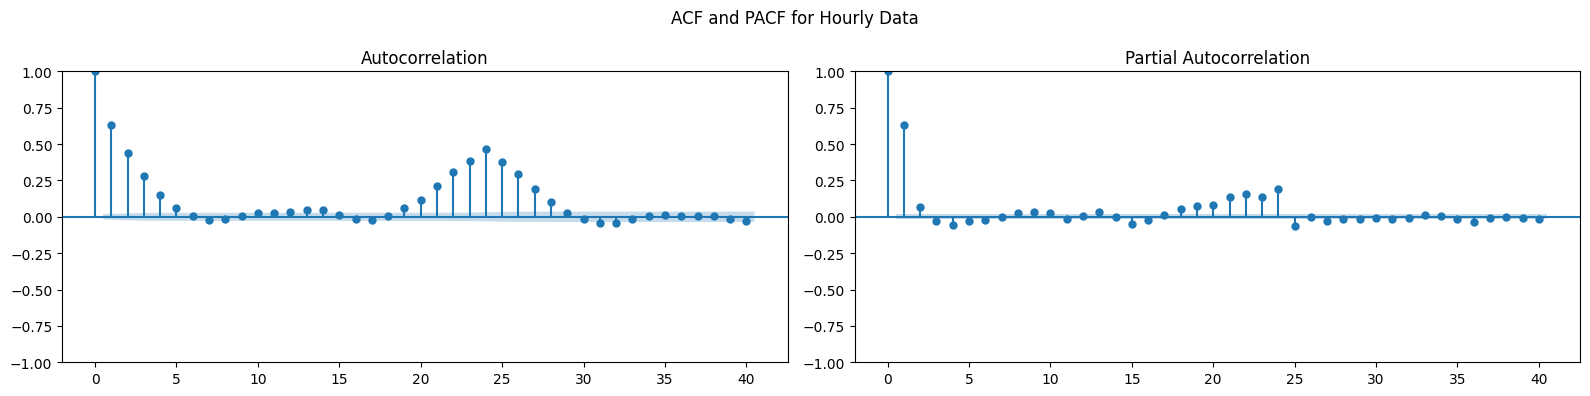

In [178]:
test_stationarity(hourly_data['consumption'], "Hourly")

## Daily data

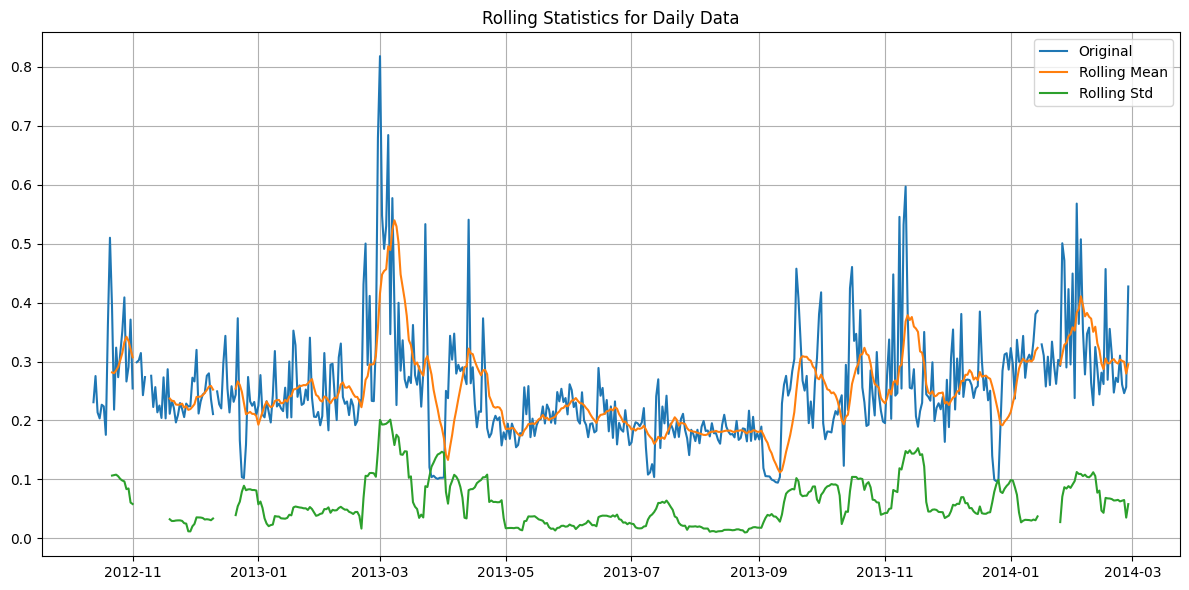

ADF Test Results:
ADF Statistic: -4.9233
p-value: 0.0000
Critical Values:
	1%: -3.4438
	5%: -2.8675
	10%: -2.5699
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.3574
p-value: 0.0955
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


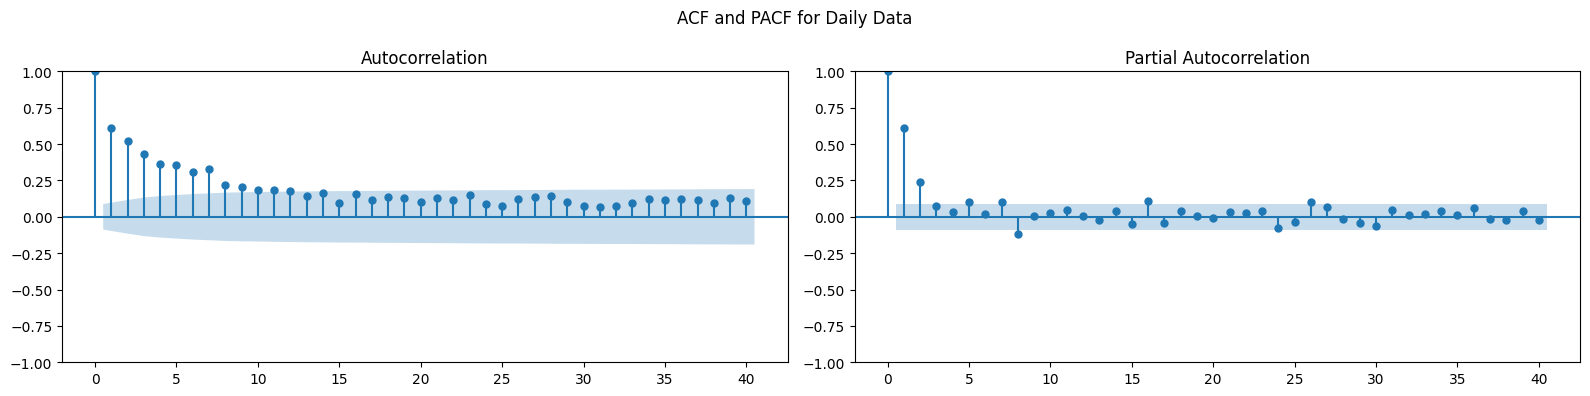

In [181]:
test_stationarity(daily_data['consumption'], "Daily")

# ETS Models

## Split data into train and test sets

### For Hourly Data

In [195]:
def fit_ets_models(timeseries, title, train_size=0.8):

    n = len(timeseries)
    train_size = int(train_size * n)
    train = timeseries.iloc[:train_size]
    test = timeseries.iloc[train_size:]
    print(f"Training set size: {len(train)}")
    print(f"Test set size: {len(test)}")

    seasonal_period = {'Hourly': 24, 'Daily': 7, 'Weekly': 4, 'Monthly': 12, 'Annual': 1}.get(title, 12)

    models = {
        'Simple Exponential Smoothing': {'trend': None, 'seasonal': None},
        'Holt Linear': {'trend': 'add', 'seasonal': None},
        'Additive Seasonality': {'trend': None, 'seasonal': 'add'},
        'Holt-Winters Additive': {'trend': 'add', 'seasonal': 'add'},
    }

    if (train > 0).all():
        models.update({
            'Exponential Trend': {'trend': 'mul', 'seasonal': None},
            'Multiplicative Seasonality': {'trend': None, 'seasonal': 'mul'},
            'Holt-Winters Multiplicative': {'trend': 'mul', 'seasonal': 'mul'},
        })

    results = {}

    for name, params in models.items():
        try:
            model = ExponentialSmoothing(
                train,
                trend=params['trend'],
                seasonal=params['seasonal'],
                seasonal_periods=seasonal_period if params['seasonal'] else None
            )
            fit_model = model.fit(optimized=True)
            forecast = fit_model.forecast(len(test))

            mse = mean_squared_error(test, forecast)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test, forecast)
            mape = mean_absolute_percentage_error(test, forecast) * 100

            results[name] = {
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'Forecast': forecast,
                'Model': fit_model
            }

            print(f"\n{name} Results:")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"MAPE: {mape:.2f}%")

        except Exception as e:
            print(f"Error with {name}: {str(e)}")

    best_model = min(results.items(), key=lambda x: x[1]['RMSE'])
    print(f"\nBest model for {title} data: {best_model[0]}")
    print(f"RMSE: {best_model[1]['RMSE']:.4f}")

    plt.figure(figsize=(14, 6))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, best_model[1]['Forecast'].values, label=f'Forecast ({best_model[0]})')
    plt.title(f'Actual vs Forecast for {title} Data - {best_model[0]}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return best_model, results

## Hourly Data

The graph shows actual hourly data (blue) with significant spikes compared to a more regular additive seasonality forecast model (orange). The metrics confirm that among all tested models, Additive Seasonality performed best with the lowest RMSE (0.2272) and MAE (0.1456), though Multiplicative Seasonality had a better MAPE (43%). The model captures the regular cyclical patterns but struggles with the unpredictable spikes in the actual data.

Training set size: 9560
Test set size: 2390

Simple Exponential Smoothing Results:
RMSE: 0.2702
MAE: 0.1740
MAPE: 66.10%

Holt Linear Results:
RMSE: 0.2721
MAE: 0.1743
MAPE: 64.65%

Additive Seasonality Results:
RMSE: 0.2272
MAE: 0.1456
MAPE: 61.94%

Holt-Winters Additive Results:
RMSE: 0.2289
MAE: 0.1471
MAPE: 62.26%

Exponential Trend Results:
RMSE: 9575109237081498015760384.0000
MAE: 1727471765704575836749824.0000
MAPE: 900662482809627479298277376.00%

Multiplicative Seasonality Results:
RMSE: 0.2278
MAE: 0.1300
MAPE: 43.00%

Holt-Winters Multiplicative Results:
RMSE: 0.3698
MAE: 0.2644
MAPE: 87.02%

Best model for Hourly data: Additive Seasonality
RMSE: 0.2272


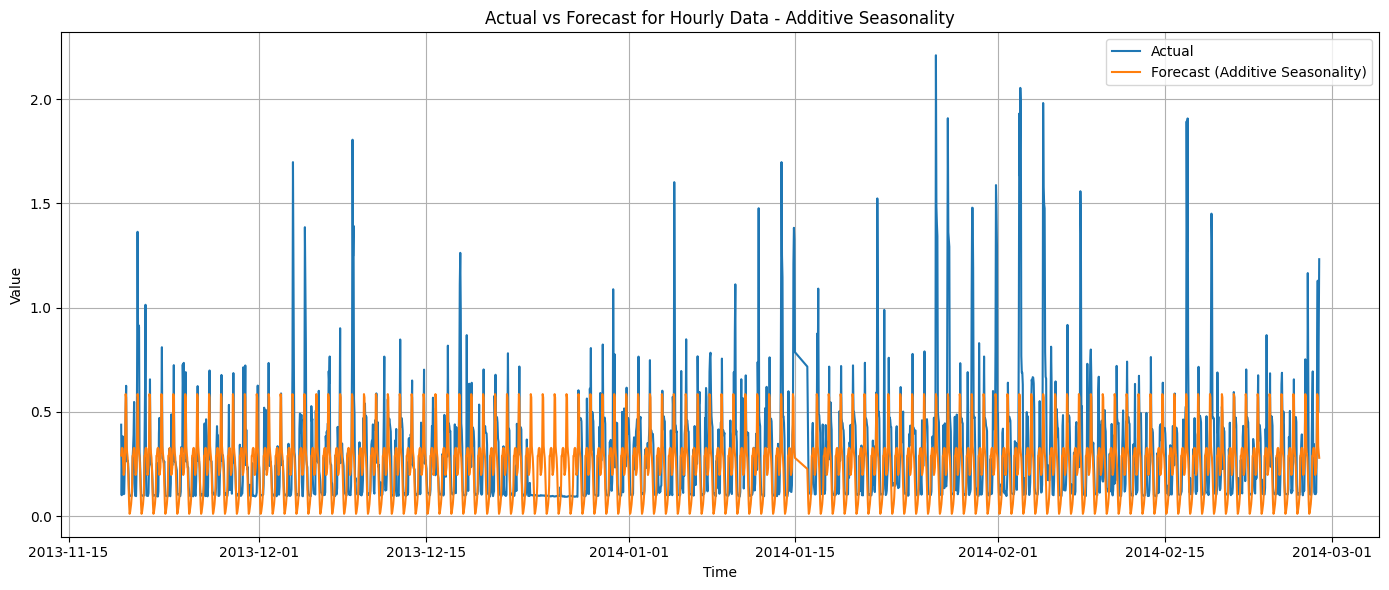

In [196]:
best_model, results = fit_ets_models(hourly_data['consumption'].dropna(), title='Hourly')

Training set size: 398
Test set size: 100

Simple Exponential Smoothing Results:
RMSE: 0.1063
MAE: 0.0827
MAPE: 27.59%

Holt Linear Results:
RMSE: 0.1083
MAE: 0.0849
MAPE: 28.26%

Additive Seasonality Results:
RMSE: 0.1049
MAE: 0.0803
MAPE: 26.65%

Holt-Winters Additive Results:
RMSE: 0.1070
MAE: 0.0824
MAPE: 27.30%

Exponential Trend Results:
RMSE: 0.1848
MAE: 0.1591
MAPE: 51.12%

Multiplicative Seasonality Results:
RMSE: 0.1113
MAE: 0.0879
MAPE: 28.97%

Holt-Winters Multiplicative Results:
RMSE: 0.2056
MAE: 0.1791
MAPE: 57.30%

Best model for Daily data: Additive Seasonality
RMSE: 0.1049


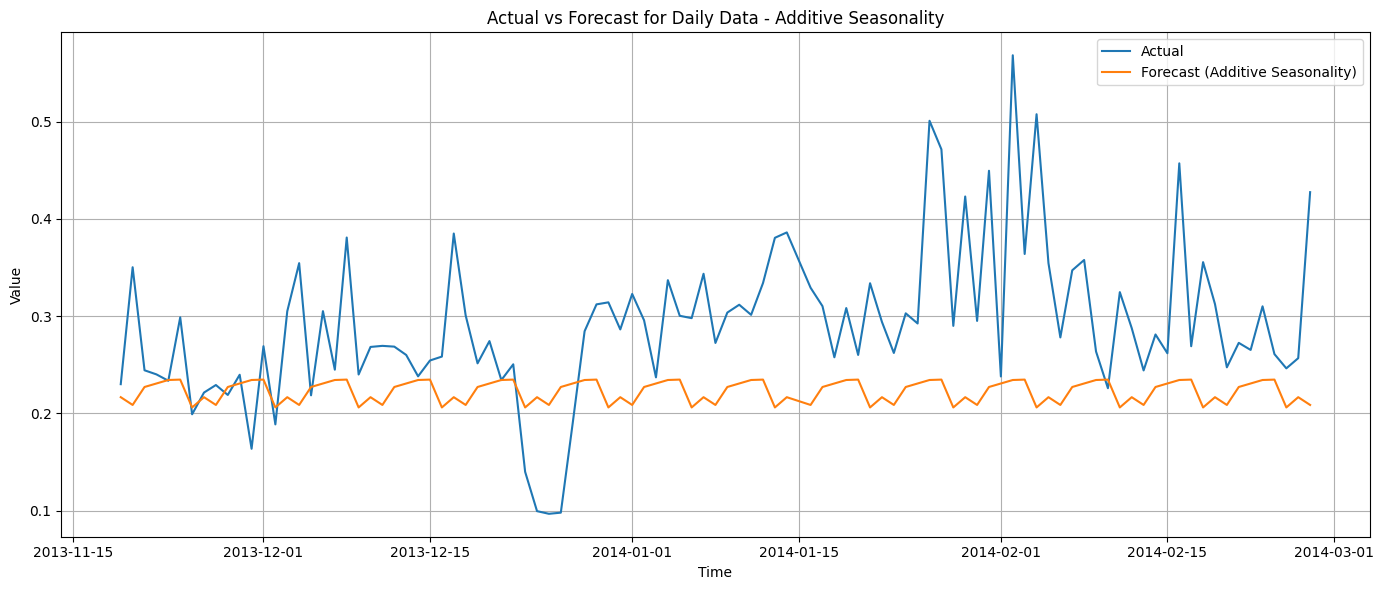

In [197]:
best_model, results = fit_ets_models(daily_data['consumption'].dropna(), title='Daily')